In [ ]:
abstract type _Filter end
abstract type _Smoother end

In [ ]:
function at_least2d(𝐀)
    if typeof(𝐀) <: Array
        if ndims(𝐀) > 1
            nothing # array already at least 2d
        else
            𝑛 = length(𝐀)
            𝐀 = reshape(float(𝐀),𝑛,1)
        end
    elseif typeof(𝐀) <: Number
        𝐀 = reshape([Float64(𝐀)],1,1)
    end
    return 𝐀
end

function feval(𝑓, 𝐱, 𝐮 = nothing)
    if typeof(𝑓) <: Matrix
        𝐲 = 𝑓 * 𝐱
        if 𝐮 ≠ nothing
            𝐲 += 𝐮
        end
    elseif typeof(𝑓) <: Function
        if 𝐮 ≠ nothing
            𝐲 = 𝑓(𝐱, 𝐮)
        else
            𝐲 = 𝑓(𝐱)
        end
    else
        println("Could not infer type 𝑓, applying identity")
        return 𝐱
    end
    return 𝐲
end


feval (generic function with 2 methods)

In [ ]:
struct State
    𝔼   :: Vector{Float64}
    cov :: Matrix{Float64}
end

type KalmanFilter <: _Filter
    
    # States
    𝐱ₜ   :: State
    𝐱₀₋ₜ :: Array{State}

    # Dynamic process
    𝐅  :: Matrix{Float64}
    𝐔ᶠ :: Matrix{Float64}

    # Observation
    𝐇 :: Matrix{Float64}
    𝐔ʰ :: Matrix{Float64}

    # Noise terms
    𝐐 :: Matrix{Float64}
    𝐑 :: Matrix{Float64}

    # Dimensions
    𝑛ˣ :: Int
    𝑛ʸ :: Int
    𝑡  :: Int

    function KalmanFilter(𝐱₀, 𝐏₀, 𝐅, 𝐐, 𝐔ᶠ, 𝐇, 𝐑, 𝐔ʰ)
        if !(typeof(𝐱₀) <: Array)
            𝐱₀ = Vector{Float64}([𝐱₀])
        end
        𝑛ˣ = length(𝐱₀)
    
        𝐏₀ = at_least2d(𝐏₀)
        𝐅  = at_least2d(𝐅)
        𝐔ᶠ = at_least2d(𝐔ᶠ)
        𝐐  = at_least2d(𝐐)
        𝐇  = at_least2d(𝐇)
        𝐔ʰ = at_least2d(𝐔ʰ)
        𝐑  = at_least2d(𝐑)
    
        𝑛ʸ = size(𝐇,1)
    
        𝐱 = State(𝐱₀, 𝐏₀)
        kf = new(𝐱, Array{State}([𝐱]),
                 𝐅, 𝐔ᶠ,
                 𝐇, 𝐔ʰ,
                 𝐐, 𝐑,
                 𝑛ˣ, 𝑛ʸ, 1)
        return kf
    end
    
    function KalmanFilter(𝐱₀, 𝐏₀)
        if !(typeof(𝐱₀) <: Array)
            𝐱₀ = Vector{Float64}([𝐱₀])
        end
        𝑛ˣ = length(𝐱₀)
        
        return KalmanFilter(𝐱₀, 𝐏₀, eye(𝑛ˣ), zeros(𝑛ˣ,𝑛ˣ), zeros(𝑛ˣ,𝑛ˣ), eye(𝑛ˣ), zeros(𝑛ˣ,𝑛ˣ), zeros(𝑛ˣ,𝑛ˣ))
        
    end
    
    function KalmanFilter(𝐱₀, 𝐏₀, 𝐅, 𝐐)
        if !(typeof(𝐱₀) <: Array)
            𝐱₀ = Vector{Float64}([𝐱₀])
        end
        𝑛ˣ = length(𝐱₀)
        
        return KalmanFilter(𝐱₀, 𝐏₀, 𝐅, 𝐐, zeros(𝑛ˣ,𝑛ˣ), eye(𝑛ˣ), zeros(𝑛ˣ,𝑛ˣ), zeros(𝑛ˣ,𝑛ˣ))
        
    end
    
    function KalmanFilter(𝐱₀, 𝐏₀, 𝐅, 𝐐, 𝐔ᶠ)
        if !(typeof(𝐱₀) <: Array)
            𝐱₀ = Vector{Float64}([𝐱₀])
        end
        𝑛ˣ = length(𝐱₀)
        
        return KalmanFilter(𝐱₀, 𝐏₀, 𝐅, 𝐐, 𝐔ᶠ, eye(𝑛ˣ), zeros(𝑛ˣ,𝑛ˣ), zeros(𝑛ˣ,𝑛ˣ))
        
    end
    
    function KalmanFilter(𝐱₀, 𝐏₀, 𝐅, 𝐐, 𝐇, 𝐑)
        if !(typeof(𝐱₀) <: Array)
            𝐱₀ = Vector{Float64}([𝐱₀])
        end
        𝑛ˣ = length(𝐱₀)
        
        return KalmanFilter(𝐱₀, 𝐏₀, 𝐅, 𝐐, zeros(𝑛ˣ,𝑛ˣ), 𝐇, 𝐑, zeros(𝑛ˣ,𝑛ˣ))
        
    end
    
end

function predict!(kf::KalmanFilter, 𝐮 = nothing, 𝐐 = nothing)  
    𝑥ₜ₋₁ = kf.𝐱ₜ.𝔼
    𝑃ₜ₋₁ = kf.𝐱ₜ.cov
    
    if 𝐮 ≠ nothing
        𝑥ₜ = feval(kf.𝐅, 𝑥ₜ₋₁, kf.𝐔ᶠ * 𝐮)
    else
        𝑥ₜ = feval(kf.𝐅, 𝑥ₜ₋₁)
    end
        
    if 𝐐 ≠ nothing
        kf.𝐐 = 𝐐
    end
    
    𝑃ₜ = kf.𝐅 * 𝑃ₜ₋₁ * kf.𝐅' + kf.𝐐
    
    kf.𝐱ₜ = State(𝑥ₜ, 𝑃ₜ)
    
    kf.𝑡 += 1
    if kf.𝑡 ≤ length(kf.𝐱₀₋ₜ)
        kf.𝐱₀₋ₜ[kf.𝑡] = kf.𝐱ₜ
    else
        push!(kf.𝐱₀₋ₜ, kf.𝐱ₜ)
    end
end

function update!(kf::KalmanFilter, 𝐲, 𝐮 = nothing, 𝐑 = nothing)
    𝑥ₜ = kf.𝐱ₜ.𝔼
    𝑃ₜ = kf.𝐱ₜ.cov
    
    if 𝐮 ≠ nothing
        𝑦ₜ = feval(kf.𝐇, 𝑥ₜ, kf.𝐔ʰ * 𝐮)
    else
        𝑦ₜ = feval(kf.𝐇, 𝑥ₜ)
    end
    
    if 𝐑 ≠ nothing
        kf.𝐑 = 𝐑
    end
    
    𝑃ˣʸ = 𝑃ₜ * kf.𝐇'
    𝑃ʸ = kf.𝐇 * 𝑃ˣʸ + kf.𝐑
    
    𝐊ₜ = 𝑃ˣʸ / 𝑃ʸ
    
#     𝑥ₜ = 𝑥ₜ + 𝐊ₜ * (𝐲 - 𝑦ₜ)
#     𝑃ₜ = 𝑃ₜ - 𝐊ₜ * 𝑃ʸ * 𝐊ₜ'
    𝑥ₜ += 𝐊ₜ * (𝐲 - 𝑦ₜ)
    𝑃ₜ -= 𝐊ₜ * 𝑃ʸ * 𝐊ₜ'
    
    kf.𝐱ₜ = State(𝑥ₜ, 𝑃ₜ)
    kf.𝐱₀₋ₜ[kf.𝑡] = kf.𝐱ₜ
end

function preallocate!(kf::KalmanFilter, 𝑛ₜ)
    𝑛 = length(kf.𝐱₀₋ₜ)
    if 𝑛 < 𝑛ₜ && kf.𝑡 < 𝑛ₜ
        append!(kf.𝐱₀₋ₜ,Array{State}(𝑛ₜ - 𝑛))
    end
end

preallocate! (generic function with 1 method)

In [ ]:
𝐅 = [1. 1. 0.;
     0. 1. 1.;
     0. 0. 1.]
𝐇 = [1. 0. 0.]

𝐐 = [0. 0. 0. ; 0. 0.01 0. ; 0. 0. 0.001]
𝐑 = at_least2d(400)

𝐱₀ = [0., 0.1, 0.05]
𝐏₀ = [10. 0. 0.; 0. 1. 0.; 0. 0. 0.1]

𝑛ˣ, 𝑛ʸ, 𝑛ᵗ = 3, 1, 100

(3, 1, 100)

In [5]:
# noise free
𝐱ⁿ = zeros(𝑛ˣ, 𝑛ᵗ)
𝐲ⁿ = zeros(𝑛ʸ, 𝑛ᵗ)

for 𝑖 ∈ 1:𝑛ᵗ
    if 𝑖 == 1
        𝐱ⁿ[:,𝑖] = 𝐱₀
    else
        𝐱ⁿ[:,𝑖] = 𝐅 * 𝐱ⁿ[:,𝑖-1]
    end
    𝐲ⁿ[:,𝑖] = 𝐇 * 𝐱ⁿ[:,𝑖]
end


# noisy
𝐱⁺ = zeros(𝑛ˣ, 𝑛ᵗ)
𝐲⁺ = zeros(𝑛ʸ, 𝑛ᵗ)
𝐲ᵒ = zeros(𝑛ʸ, 𝑛ᵗ)

for 𝑖 ∈ 1:𝑛ᵗ
    if 𝑖 == 1
        𝐱⁺[:,𝑖] = 𝐱₀
    else
        𝐱⁺[:,𝑖] = 𝐅 * 𝐱⁺[:,𝑖-1] + sqrt.(𝐐) * randn(𝑛ˣ,1)
    end
    𝐲⁺[:,𝑖] = 𝐇 * 𝐱⁺[:,𝑖]
    𝐲ᵒ[:,𝑖] = 𝐲⁺[:,𝑖] + sqrt.(𝐑) * randn(𝑛ʸ, 1)
end

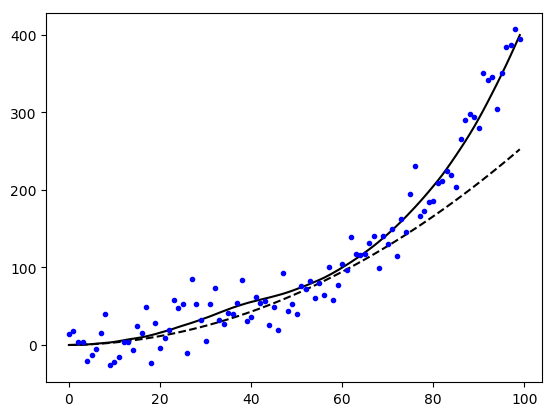

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000297A4AC8>

In [6]:
using PyPlot

plot(𝐲ⁿ',"k--")

plot(𝐲⁺',"k-")
plot(𝐲ᵒ',"b.")


In [7]:
kf = KalmanFilter(𝐱₀, 𝐏₀, 𝐅, 𝐐, 𝐇, 𝐑)
preallocate!(kf, 𝑛ᵗ)


𝐱ᵉ = zeros(𝑛ˣ, 𝑛ᵗ)
𝐏ᵉ = zeros(𝑛ˣ, 𝑛ˣ, 𝑛ᵗ)
𝐲ᵉ = zeros(𝑛ʸ, 𝑛ᵗ)

𝐱ᵉ[:,1] = 𝐱₀
𝐏ᵉ[:,:,1] = 𝐏₀
𝐲ᵉ[:,1] = 𝐇*𝐱₀

for 𝑖 ∈ 2:𝑛ᵗ
    predict!(kf)
    update!(kf, 𝐲ᵒ[:,𝑖])

    𝐱ᵉ[:,𝑖]   = kf.𝐱ₜ.𝔼
    𝐏ᵉ[:,:,𝑖] = kf.𝐱ₜ.cov
    𝐲ᵉ[:,𝑖]   = 𝐇*𝐱ᵉ[:,𝑖]
end


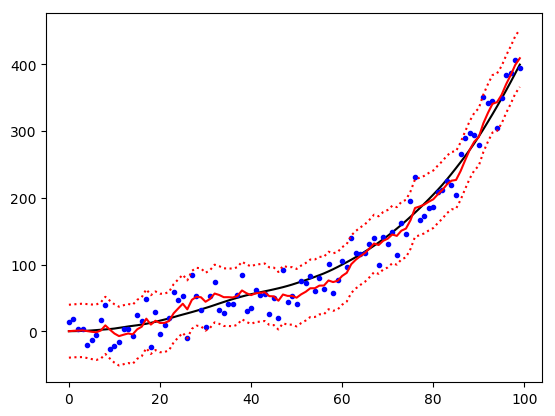

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000029A77550>

In [ ]:
using PyPlot

plot(𝐲⁺',"k-")
plot(𝐲ᵒ',"b.")

σ² = reshape(𝐏ᵉ[1,1,:] + 𝐑[1,1],𝑛ʸ,𝑛ᵗ)

plot(𝐲ᵉ',"r-")
plot(𝐲ᵉ' + 1.96*sqrt.(σ²)',"r:")
plot(𝐲ᵉ' - 1.96*sqrt.(σ²)',"r:")

In [ ]:
type RauchTungStriebelSmoother <: _Smoother
    
    𝐱₀₋ₜ :: Array{State}
    
    𝐅 :: Matrix{Float64}
    𝐔ᶠ :: Matrix{Float64}
    𝐐 :: Matrix{Float64}
    
    𝑇 :: Int
    𝑡 :: Int
    
    function RauchTungStriebelSmoother(𝐱₀₋ₜ, 𝐅, 𝐐, 𝐔ᶠ)
        rts = new(𝐱₀₋ₜ, 𝐅, 𝐔ᶠ, 𝐐, length(𝐱₀₋ₜ), length(𝐱₀₋ₜ)-1)
        return rts
    end
    
    function RauchTungStriebelSmoother(kf::KalmanFilter)
        return RauchTungStriebelSmoother(kf.𝐱₀₋ₜ, kf.𝐅, kf.𝐐, kf.𝐔ᶠ)
    end
    
    function RauchTungStribelSmoother(𝐱₀₋ₜ, 𝐅, 𝐐)
        return RauchTungStriebelSmoother(𝐱₀₋ₜ, 𝐅, 𝐐, zeros(size(𝐅)))
    end
end

function iterate_smoother!(rts::RauchTungStriebelSmoother, 𝐮 = nothing, 𝐐 = nothing)
 
    𝑡 = rts.𝑡
    
    ## Expectation prediction
    𝑥ₜ = rts.𝐱₀₋ₜ[𝑡].𝔼
    
    if 𝐮 ≠ nothing
        𝑥⁻ₜ₊₁ = feval(rts.𝐅, 𝑥ₜ, rts.𝐔ᶠ * 𝐮)
    else
        𝑥⁻ₜ₊₁ = feval(rts.𝐅, 𝑥ₜ)
    end
    
    ## Covariance prediction
    𝑃ₜ = rts.𝐱₀₋ₜ[𝑡].cov
    
    if 𝐐 ≠ nothing
        rts.𝐐 = 𝐐
    end
    
    𝑃⁻ₜ₊₁ = rts.𝐅 * 𝑃ₜ * rts.𝐅' + rts.𝐐
    
    𝐒ₜ = 𝑃ₜ * rts.𝐅 / 𝑃⁻ₜ₊₁
    
    ## Smoothing
    𝑥⁺ₜ₊₁ = rts.𝐱₀₋ₜ[𝑡+1].𝔼
    𝑃⁺ₜ₊₁ = rts.𝐱₀₋ₜ[𝑡+1].cov
    
    𝑥ₜ += 𝐒ₜ * (𝑥⁺ₜ₊₁ - 𝑥⁻ₜ₊₁)
    𝑃ₜ += 𝐒ₜ * (𝑃⁺ₜ₊₁ - 𝑃⁻ₜ₊₁) * 𝐒ₜ'
    
    rts.𝐱₀₋ₜ[𝑡] = State(𝑥ₜ, 𝑃ₜ) 
    rts.𝑡 -= 1
end

function smooth!(rts::RauchTungStriebelSmoother)
    while rts.𝑡 > 0
        iterate_smoother!(rts)
    end
    
    return rts.𝐱₀₋ₜ
end

smooth! (generic function with 1 method)

In [ ]:
rts = RauchTungStriebelSmoother(kf)
𝐱₀₋ₜ = smooth!(rts)

𝐱ˢ = zeros(𝑛ˣ, 𝑛ᵗ)
𝐏ˢ = zeros(𝑛ˣ, 𝑛ˣ, 𝑛ᵗ)
𝐲ˢ = zeros(𝑛ʸ, 𝑛ᵗ)

𝐱ˢ[:,1]   = 𝐱₀
𝐏ˢ[:,:,1] = 𝐏₀
𝐲ˢ[:,1]   = 𝐇*𝐱₀

for 𝑖 ∈ 2:𝑛ᵗ
    𝐱ˢ[:,𝑖]   = 𝐱₀₋ₜ[𝑖].𝔼
    𝐏ˢ[:,:,𝑖] = 𝐱₀₋ₜ[𝑖].cov
    𝐲ˢ[:,𝑖]   = 𝐇*𝐱ˢ[:,𝑖]
end


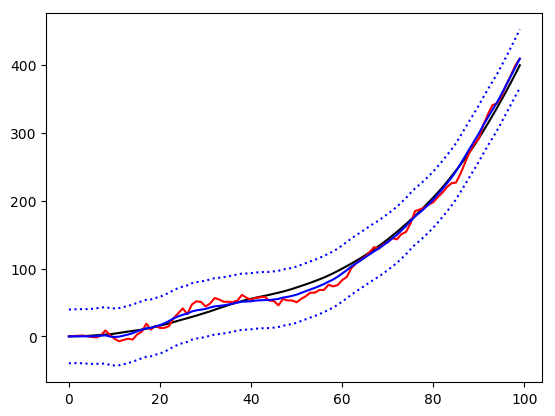

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000029B27358>

In [11]:
using PyPlot

plot(𝐲⁺',"k-")
plot(𝐲ᵉ',"r-")
#plot(𝐲ᵒ',"b.")

σ² = reshape(𝐏ˢ[1,1,:] + 𝐑[1,1],𝑛ʸ,𝑛ᵗ)
plot(𝐲ˢ',"b-")
plot(𝐲ˢ' + 1.96*sqrt.(σ²)',"b:")
plot(𝐲ˢ' - 1.96*sqrt.(σ²)',"b:")